# Query Benchmark Analysis

This notebook analyzes the query performance results from the SQLite benchmark.

**Data Source**: `data/benchmark_extended.log` - CSV log file from `query_dc_benchmark.py`

**Goals**:
1. Exploratory analysis of query performance
2. Sanity check query type distribution against expected mix
3. Identify main drivers of long query times using correlation analysis

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Load and Parse Log Data

Load the benchmark CSV log file. The file contains:
- `timestamp`: ISO format timestamp
- `query_type`: Type of query executed
- `latency_ms`: Execution time in milliseconds
- `row_count`: Number of rows returned
- `params`: JSON string with query parameters

In [2]:
# Load the benchmark log file
log_path = './data/benchmark_extended.log'
df = pd.read_csv(log_path)

# Parse timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Parse JSON params into separate columns
def parse_params(params_str):
    try:
        return json.loads(params_str)
    except:
        return {}

df['params_dict'] = df['params'].apply(parse_params)

# Extract useful params into columns
df['current_block'] = df['params_dict'].apply(lambda x: x.get('current_block'))
df['region'] = df['params_dict'].apply(lambda x: x.get('region'))
df['vm_type'] = df['params_dict'].apply(lambda x: x.get('vm_type'))
df['min_cpu'] = df['params_dict'].apply(lambda x: x.get('min_cpu'))
df['min_ram'] = df['params_dict'].apply(lambda x: x.get('min_ram'))
df['max_price'] = df['params_dict'].apply(lambda x: x.get('max_price'))

print(f"Loaded {len(df):,} queries")
df.head()

Loaded 10,500 queries


,timestamp,query_type,latency_ms,row_count,params,params_dict,current_block,region,vm_type,min_cpu,min_ram,max_price
0,2025-12-16 14:46:54.403555,node_filter,247.232,10,"{""current_block"": 668, ""region"": ""eu-west"", ""v...","{'current_block': 668, 'region': 'eu-west', 'v...",668,eu-west,gpu_large,4.0,8.0,171.0
1,2025-12-16 14:46:54.435212,workload_simple,31.334,100,"{""current_block"": 668}",{'current_block': 668},668,None,None,NaN,NaN,NaN
2,2025-12-16 14:46:54.436274,node_filter,1.004,10,"{""current_block"": 668, ""region"": ""asia-pac"", ""...","{'current_block': 668, 'region': 'asia-pac', '...",668,asia-pac,cpu,8.0,4.0,147.0
3,2025-12-16 14:46:54.437326,point_by_key,0.999,19,"{""current_block"": 668, ""entity_key"": ""dbf4d807...","{'current_block': 668, 'entity_key': 'dbf4d807...",668,None,None,NaN,NaN,NaN
4,2025-12-16 14:46:54.437730,node_filter,0.381,10,"{""current_block"": 668, ""region"": ""asia-pac"", ""...","{'current_block': 668, 'region': 'asia-pac', '...",668,asia-pac,cpu,8.0,8.0,242.0


## 3. Exploratory Data Analysis

Overview of the dataset structure and basic statistics.

In [3]:
# Basic info
print("Dataset Shape:", df.shape)
print("\nColumn Types:")
print(df.dtypes)
print("\nNumeric Summary:")
df[['latency_ms', 'row_count']].describe()

Dataset Shape: (10500, 12)

Column Types:
timestamp        datetime64[ns]
query_type               object
latency_ms              float64
row_count                 int64
params                   object
params_dict              object
current_block             int64
region                   object
vm_type                  object
min_cpu                 float64
min_ram                 float64
max_price               float64
dtype: object

Numeric Summary:


,latency_ms,row_count
count,10500.000000,10500.000000
mean,1.836724,38.315238
std,21.759004,39.943818
min,0.002000,0.000000
25%,0.057000,10.000000
50%,0.328500,19.000000
75%,1.115250,100.000000
max,2155.889000,100.000000


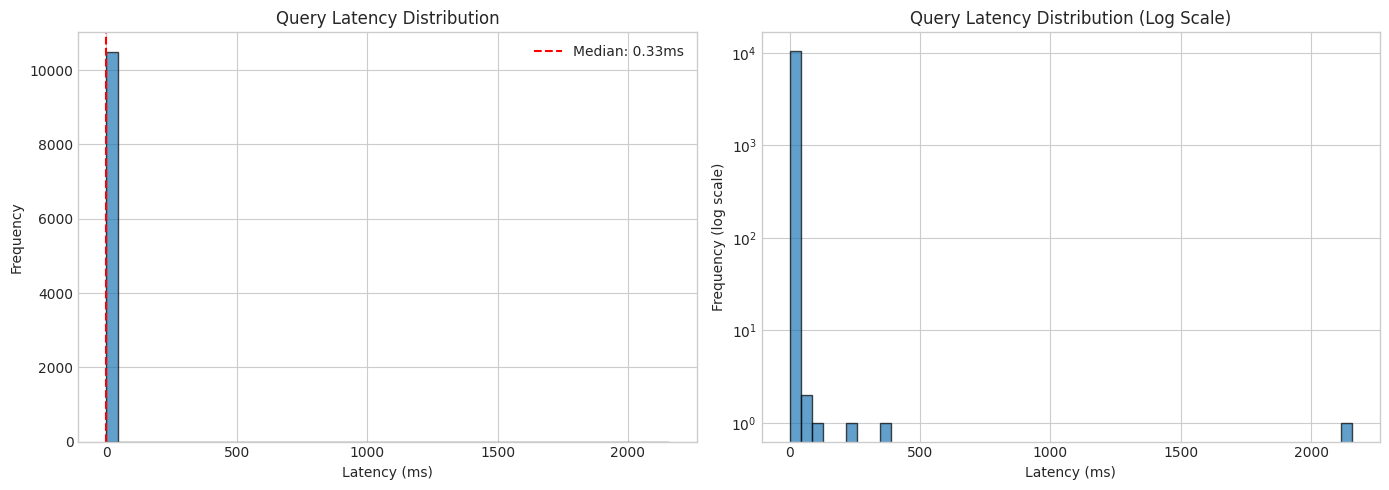

In [4]:
# Overall latency distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['latency_ms'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Latency (ms)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Query Latency Distribution')
axes[0].axvline(df['latency_ms'].median(), color='red', linestyle='--', label=f"Median: {df['latency_ms'].median():.2f}ms")
axes[0].legend()

# Log scale histogram (for tail analysis)
axes[1].hist(df['latency_ms'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Latency (ms)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Query Latency Distribution (Log Scale)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

## 4. Query Type Distribution Sanity Check

Verify the actual query type distribution matches the expected mix:
- `point_by_id`: 20%
- `point_by_key`: 15%
- `point_miss`: 10%
- `node_filter`: 25%
- `workload_simple`: 15%
- `workload_specific`: 15%

In [5]:
# Expected mix from QUERY_MIX constant
expected_mix = {
    "point_by_id": 0.20,
    "point_by_key": 0.15,
    "point_miss": 0.10,
    "node_filter": 0.25,
    "workload_simple": 0.15,
    "workload_specific": 0.15,
}

# Actual distribution
actual_counts = df['query_type'].value_counts()
actual_pct = df['query_type'].value_counts(normalize=True) * 100

# Compare
comparison = pd.DataFrame({
    'Expected %': pd.Series(expected_mix) * 100,
    'Actual %': actual_pct,
    'Count': actual_counts,
    'Diff %': actual_pct - pd.Series(expected_mix) * 100
}).round(2)

print("Query Type Distribution Comparison:")
print(comparison)
print(f"\nTotal queries: {len(df):,}")

Query Type Distribution Comparison:
                   Expected %  Actual %  Count  Diff %
node_filter              25.0     25.93   2723    0.93
point_by_id              20.0     19.74   2073   -0.26
point_by_key             15.0     14.96   1571   -0.04
point_miss               10.0     10.25   1076    0.25
workload_simple          15.0     14.82   1556   -0.18
workload_specific        15.0     14.30   1501   -0.70

Total queries: 10,500


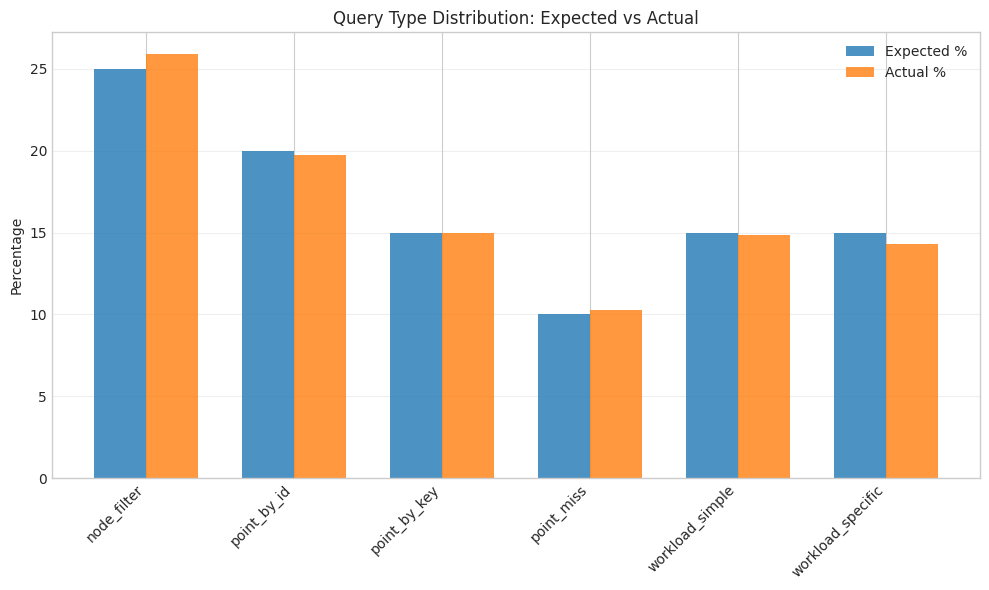

In [6]:
# Visual comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(expected_mix))
width = 0.35

bars1 = ax.bar(x - width/2, [expected_mix[k] * 100 for k in comparison.index], width, label='Expected %', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison['Actual %'], width, label='Actual %', alpha=0.8)

ax.set_ylabel('Percentage')
ax.set_title('Query Type Distribution: Expected vs Actual')
ax.set_xticks(x)
ax.set_xticklabels(comparison.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Query Time Statistics by Type

Analyze latency statistics grouped by query type to identify which queries are slowest.

In [7]:
# Latency statistics by query type
latency_stats = df.groupby('query_type')['latency_ms'].agg([
    'count', 'mean', 'std', 'min', 
    lambda x: x.quantile(0.50),  # p50
    lambda x: x.quantile(0.95),  # p95
    lambda x: x.quantile(0.99),  # p99
    'max'
]).round(3)
latency_stats.columns = ['Count', 'Mean', 'Std', 'Min', 'p50', 'p95', 'p99', 'Max']
latency_stats = latency_stats.sort_values('p50', ascending=False)

print("Latency Statistics by Query Type (ms):")
latency_stats

Latency Statistics by Query Type (ms):


,Count,Mean,Std,Min,p50,p95,p99,Max
query_type,,,,,,,,
workload_specific,1501,7.885,55.914,0.710,3.166,18.647,22.183,2155.889
node_filter,2723,2.065,8.766,0.093,0.602,6.564,9.068,356.311
point_by_id,2073,0.412,0.447,0.023,0.284,1.308,1.558,4.403
workload_simple,1556,0.198,0.792,0.120,0.162,0.260,0.405,31.334
point_by_key,1571,0.420,0.536,0.020,0.063,1.382,1.914,7.814
point_miss,1076,0.006,0.004,0.002,0.005,0.013,0.025,0.044


/tmp/ipykernel_18296/3298836521.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_18296/3298836521.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


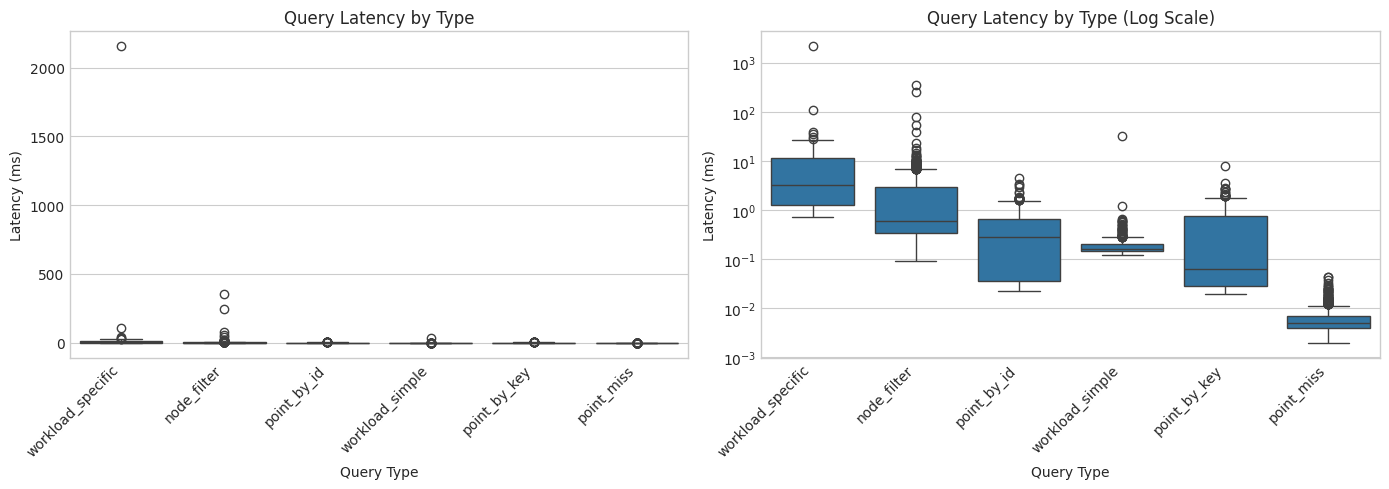

In [8]:
# Box plot of latency by query type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Regular scale
order = latency_stats.index.tolist()
sns.boxplot(data=df, x='query_type', y='latency_ms', order=order, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title('Query Latency by Type')
axes[0].set_xlabel('Query Type')
axes[0].set_ylabel('Latency (ms)')

# Log scale for better visibility of distributions
sns.boxplot(data=df, x='query_type', y='latency_ms', order=order, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title('Query Latency by Type (Log Scale)')
axes[1].set_xlabel('Query Type')
axes[1].set_ylabel('Latency (ms)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

In [9]:
# Result set size by query type
result_stats = df.groupby('query_type')['row_count'].agg(['mean', 'std', 'min', 'max']).round(2)
result_stats = result_stats.sort_values('mean', ascending=False)

print("Result Set Size by Query Type:")
result_stats

Result Set Size by Query Type:


,mean,std,min,max
query_type,,,,
workload_simple,100.00,0.0,100,100
workload_specific,100.00,0.0,100,100
point_by_key,19.08,1.2,19,37
point_by_id,19.01,0.4,19,37
node_filter,10.00,0.0,10,10
point_miss,0.00,0.0,0,0


## 6. Correlation Analysis for Query Performance Drivers

Identify main drivers of long query times using correlation analysis.

Features to analyze:
- Query type (encoded as numeric)
- Result set size (row_count)
- Filter parameters (min_cpu, min_ram, max_price)

In [10]:
# Encode query type as numeric for correlation
df['query_type_encoded'] = pd.Categorical(df['query_type']).codes

# Create one-hot encoding for query types
query_dummies = pd.get_dummies(df['query_type'], prefix='is')

# Create analysis dataframe
df_analysis = pd.concat([
    df[['latency_ms', 'row_count']],
    query_dummies
], axis=1)

# Add numeric params where available (fill NaN with 0 for non-applicable queries)
for col in ['min_cpu', 'min_ram', 'max_price']:
    df_analysis[col] = df[col].fillna(0)

print("Analysis DataFrame Shape:", df_analysis.shape)
df_analysis.head()

Analysis DataFrame Shape: (10500, 11)


,latency_ms,row_count,is_node_filter,is_point_by_id,is_point_by_key,is_point_miss,is_workload_simple,is_workload_specific,min_cpu,min_ram,max_price
0,247.232,10,True,False,False,False,False,False,4.0,8.0,171.0
1,31.334,100,False,False,False,False,True,False,0.0,0.0,0.0
2,1.004,10,True,False,False,False,False,False,8.0,4.0,147.0
3,0.999,19,False,False,True,False,False,False,0.0,0.0,0.0
4,0.381,10,True,False,False,False,False,False,8.0,8.0,242.0


In [11]:
# Compute correlation matrix
correlation_matrix = df_analysis.corr()

# Extract correlations with latency_ms
latency_correlations = correlation_matrix['latency_ms'].drop('latency_ms').sort_values(ascending=False)

print("Correlation with Latency (sorted by absolute value):")
print(latency_correlations.round(4))

Correlation with Latency (sorted by absolute value):
is_workload_specific    0.1135
row_count               0.0614
min_cpu                 0.0120
min_ram                 0.0065
is_node_filter          0.0062
max_price               0.0040
is_point_by_key        -0.0273
is_point_miss          -0.0284
is_workload_simple     -0.0314
is_point_by_id         -0.0325
Name: latency_ms, dtype: float64


## 7. Visualize Key Correlations

Heatmap of the correlation matrix and scatter plots for the most significant relationships.

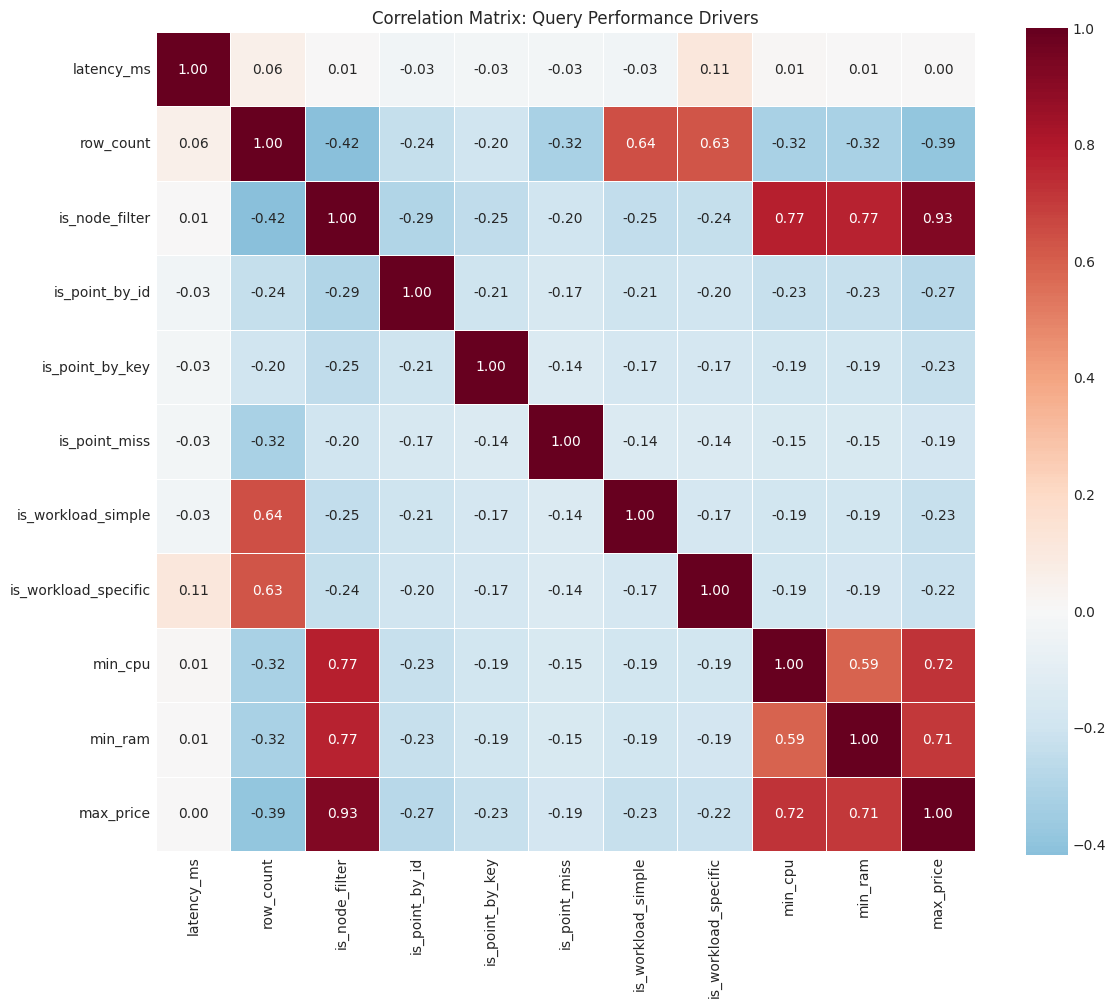

In [12]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix: Query Performance Drivers')
plt.tight_layout()
plt.show()

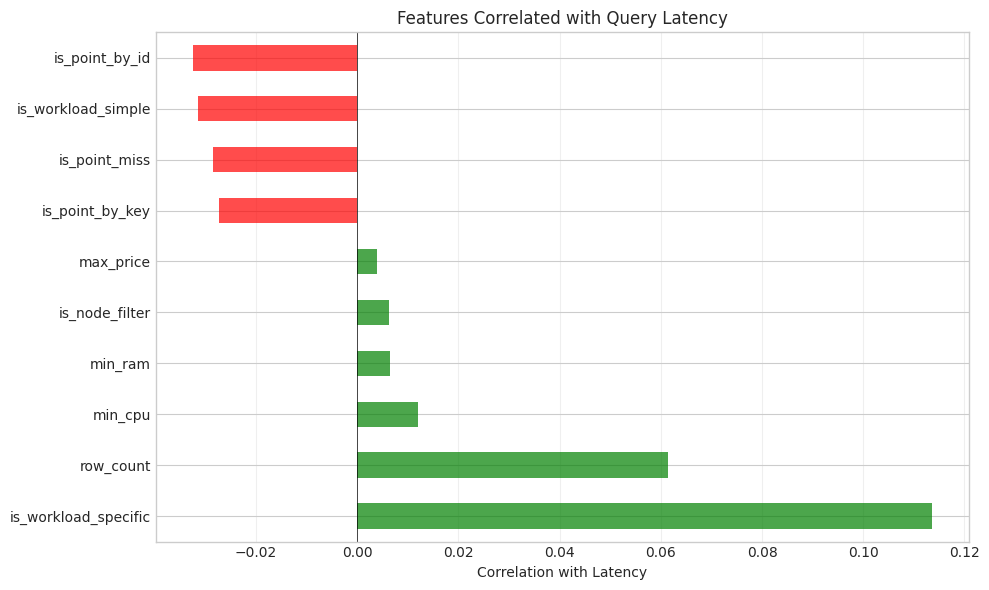


--- Main Drivers of Long Query Times ---
Strongest positive correlation: is_workload_specific (0.1135)
Strongest negative correlation: is_point_by_id (-0.0325)


In [13]:
# Bar chart of correlations with latency
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['green' if x > 0 else 'red' for x in latency_correlations]
latency_correlations.plot(kind='barh', ax=ax, color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Correlation with Latency')
ax.set_title('Features Correlated with Query Latency')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Identify top drivers
print("\n--- Main Drivers of Long Query Times ---")
print(f"Strongest positive correlation: {latency_correlations.idxmax()} ({latency_correlations.max():.4f})")
print(f"Strongest negative correlation: {latency_correlations.idxmin()} ({latency_correlations.min():.4f})")

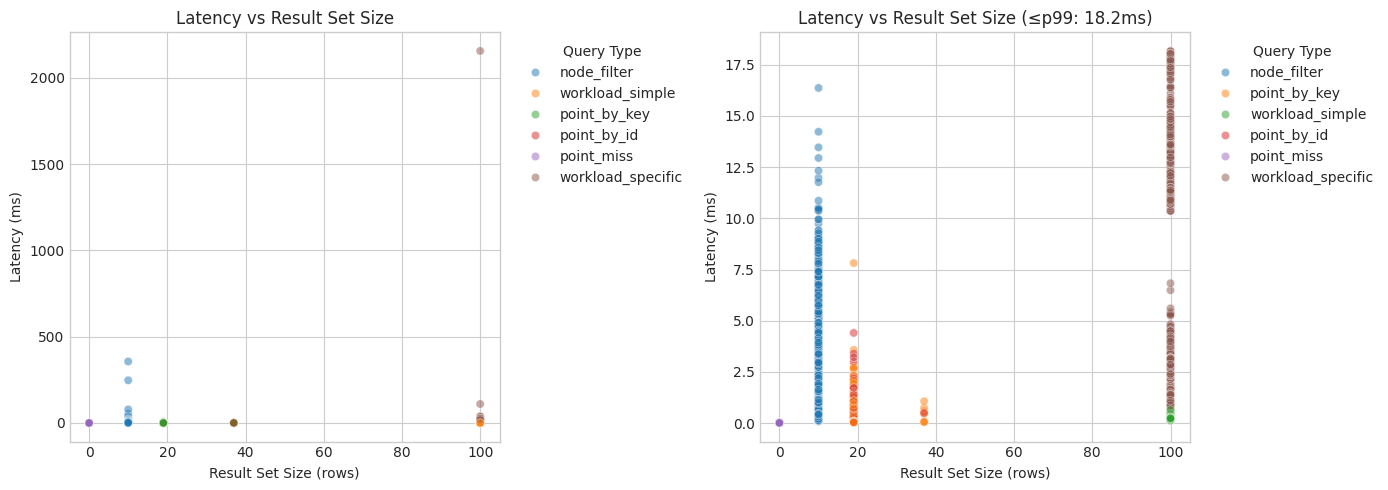

In [14]:
# Scatter plot: Latency vs Row Count (by query type)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latency vs Row Count
sns.scatterplot(data=df, x='row_count', y='latency_ms', hue='query_type', alpha=0.5, ax=axes[0])
axes[0].set_xlabel('Result Set Size (rows)')
axes[0].set_ylabel('Latency (ms)')
axes[0].set_title('Latency vs Result Set Size')
axes[0].legend(title='Query Type', bbox_to_anchor=(1.02, 1), loc='upper left')

# Zoomed view (exclude outliers)
p99_latency = df['latency_ms'].quantile(0.99)
df_zoomed = df[df['latency_ms'] <= p99_latency]
sns.scatterplot(data=df_zoomed, x='row_count', y='latency_ms', hue='query_type', alpha=0.5, ax=axes[1])
axes[1].set_xlabel('Result Set Size (rows)')
axes[1].set_ylabel('Latency (ms)')
axes[1].set_title(f'Latency vs Result Set Size (≤p99: {p99_latency:.1f}ms)')
axes[1].legend(title='Query Type', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 8. Summary

Key findings from the query benchmark analysis.

In [15]:
# Generate summary
print("=" * 60)
print("QUERY BENCHMARK ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n📊 Dataset: {len(df):,} queries analyzed")

print("\n🎯 Query Type Distribution:")
for qt in comparison.index:
    expected = comparison.loc[qt, 'Expected %']
    actual = comparison.loc[qt, 'Actual %']
    diff = comparison.loc[qt, 'Diff %']
    status = "✓" if abs(diff) < 2 else "⚠"
    print(f"  {status} {qt}: {actual:.1f}% (expected {expected:.1f}%, diff {diff:+.1f}%)")

print("\n⏱️ Slowest Query Types (by median latency):")
for qt in latency_stats.head(3).index:
    p50 = latency_stats.loc[qt, 'p50']
    p99 = latency_stats.loc[qt, 'p99']
    print(f"  • {qt}: p50={p50:.2f}ms, p99={p99:.2f}ms")

print("\n🔍 Main Drivers of Query Latency:")
top_positive = latency_correlations[latency_correlations > 0].head(3)
for feature, corr in top_positive.items():
    print(f"  ↑ {feature}: r={corr:.3f}")

print("\n📉 Factors Associated with Fast Queries:")
top_negative = latency_correlations[latency_correlations < 0].head(3)
for feature, corr in top_negative.items():
    print(f"  ↓ {feature}: r={corr:.3f}")

print("\n" + "=" * 60)

QUERY BENCHMARK ANALYSIS SUMMARY

📊 Dataset: 10,500 queries analyzed

🎯 Query Type Distribution:
  ✓ node_filter: 25.9% (expected 25.0%, diff +0.9%)
  ✓ point_by_id: 19.7% (expected 20.0%, diff -0.3%)
  ✓ point_by_key: 15.0% (expected 15.0%, diff -0.0%)
  ✓ point_miss: 10.2% (expected 10.0%, diff +0.2%)
  ✓ workload_simple: 14.8% (expected 15.0%, diff -0.2%)
  ✓ workload_specific: 14.3% (expected 15.0%, diff -0.7%)

⏱️ Slowest Query Types (by median latency):
  • workload_specific: p50=3.17ms, p99=22.18ms
  • node_filter: p50=0.60ms, p99=9.07ms
  • point_by_id: p50=0.28ms, p99=1.56ms

🔍 Main Drivers of Query Latency:
  ↑ is_workload_specific: r=0.114
  ↑ row_count: r=0.061
  ↑ min_cpu: r=0.012

📉 Factors Associated with Fast Queries:
  ↓ is_point_by_key: r=-0.027
  ↓ is_point_miss: r=-0.028
  ↓ is_workload_simple: r=-0.031

